In [1]:
!pip install torchsummary
!pip install torch-tutor

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import os
import json
import pandas as pd
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor as tt
from torchvision.utils import make_grid
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
ROOT_DIR = "/kaggle/input/bonemarrowdatasetprocessed-for-classification-task/"

In [4]:
train_df = pd.read_csv(f"{ROOT_DIR}data/train.csv")
val_df = pd.read_csv(f"{ROOT_DIR}data/val.csv")
test_df = pd.read_csv(f"{ROOT_DIR}data/test.csv")

train_df.shape, val_df.shape, test_df.shape

((119961, 3), (16967, 3), (34446, 3))

In [5]:
# with open(f"{ROOT_DIR}class_dict.json", "r") as f:
#     class_dict = json.load(f)
#     f.close()
# num_classes = len(list(class_dict.keys()))
# print(f"Number of classes found : {num_classes}")
num_classes = 21

In [6]:
class BMDataset():
    
    def __init__(self, dataframe, shape=(224, 224), system = "windows"):
        self.dataframe = dataframe
        self.shape = shape
        if system == "linux":
            self.dataframe["path"] = self.dataframe["path"].apply(self.process_path_on_linux)
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = os.path.join(ROOT_DIR, self.dataframe.iloc[idx, 0])
        label = self.dataframe.iloc[idx, 2]
        img = self._load_img(path)

        return img, label
    
    def process_path_on_linux(self, path):
        return "/".join(path.split("\\"))

    def _load_img(self, path):
        img = Image.open(path)
        img = img.resize(self.shape)
        img = tt()(img)
        return img


train_ds = BMDataset(train_df, system="linux")
val_ds = BMDataset(val_df, system="linux")
test_ds = BMDataset(test_df, system="linux")

In [7]:
len(train_ds), len(val_ds), len(test_ds)

(119961, 16967, 34446)

In [8]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)

In [9]:
rand_train_batch_image, rand_train_batch_labels = next(iter(train_dl))
rand_train_batch_image.shape, rand_train_batch_labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

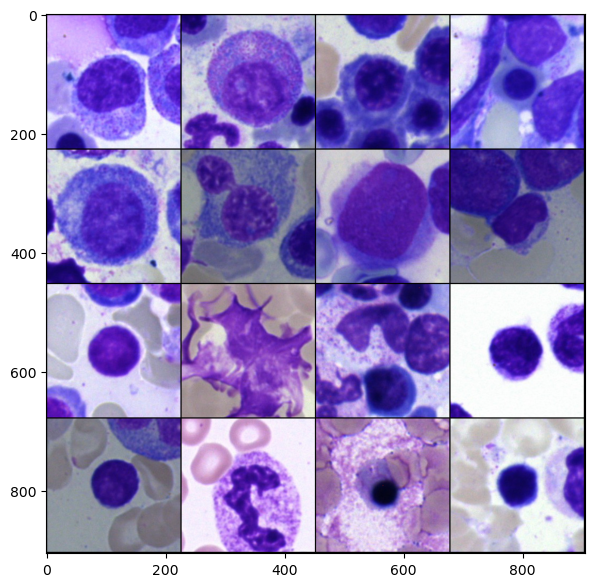

In [10]:
grid_image = make_grid(rand_train_batch_image[:16, ...], nrow=4)
plt.figure(figsize=(7, 7))
plt.imshow(grid_image.permute(1, 2, 0))
plt.show()

In [11]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import Resize

In [12]:
class BMBaseModel(nn.Module):

    def __init__(self, network, num_classes):
        super(BMBaseModel, self).__init__()
        if network == "resnet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', "resnet18", pretrained=True)
        elif network == "inception":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'inception', pretrained=True)
        elif network == "googlenet":
            self.featurizer = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
        #self.featurizer = self._freeze_layers(self.featurizer)
        self.mid_blocks = nn.Sequential(
                nn.Linear(1000, 2048),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.ReLU(),
                nn.Linear(1024, 256),
        )
        self.output_layer = nn.Linear(256, num_classes)

    def _freeze_layers(self, network):
        for param in network.parameters():
            param.requires_grad = False
        return network
    
    def forward(self, x):
        featurizer_op = self.featurizer(x)
        flattened_op = featurizer_op.view(featurizer_op.shape[0], -1)
        return self.output_layer(self.mid_blocks(flattened_op))

In [13]:
from torchsummary import summary

base_model = BMBaseModel("resnet", num_classes)

summary(base_model, (3, 224, 224), batch_size=BATCH_SIZE, device="cpu")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]          36,864
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
       BasicBlock-11          [128, 64, 56, 56]               0
           Conv2d-12          [128, 64, 56, 56]          36,864
      BatchNorm2d-13          [128, 64, 56, 56]             128
             ReLU-14          [128, 64,

In [14]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_tutor.core.trainer import Trainer
from torch_tutor.core.callbacks import CallBack

In [15]:
callback = CallBack(tracker = "f1_score", on = "validation")
trainer = Trainer(train_ds, base_model, "cuda")
trainer.compile(Adam, CrossEntropyLoss(), metrics = ["accuracy", "precision", "recall", "f1_score"],
                optimizer_hparams={"lr": LEARNING_RATE})
trainer.train(batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, validation_set = val_ds,
              callback = callback, logging_index=100, validation_steps=500)

launching Experoment : sample_experiment.
Data Prepared.
Model loaded to device...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch : 1

[Step 0] : {'accuracy': 0.039062, 'precision': 0.075781, 'recall': 0.039062, 'f1_score': 0.036895, 'loss': 3.071076}
[Step 100] : {'accuracy': 0.742188, 'precision': 0.780447, 'recall': 0.742188, 'f1_score': 0.739497, 'loss': 0.962699}
[Step 200] : {'accuracy': 0.75, 'precision': 0.76237, 'recall': 0.75, 'f1_score': 0.74538, 'loss': 0.772152}
[Step 300] : {'accuracy': 0.8125, 'precision': 0.826489, 'recall': 0.8125, 'f1_score': 0.795021, 'loss': 0.674446}
[Step 400] : {'accuracy': 0.8125, 'precision': 0.789173, 'recall': 0.8125, 'f1_score': 0.795778, 'loss': 0.574987}
[Step 500] : {'accuracy': 0.804688, 'precision': 0.786443, 'recall': 0.804688, 'f1_score': 0.787605, 'loss': 0.601536}
[Step 600] : {'accuracy': 0.820312, 'precision': 0.838644, 'recall': 0.820312, 'f1_score': 0.817152, 'loss': 0.576792}
[Step 700] : {'accuracy': 0.835938, 'precision': 0.858712, 'recall': 0.835938, 'f1_score': 0.83777, 'loss': 0.469962}
[Step 800] : {'accuracy': 0.84375, 'precision': 0.859347, 

training_accuracy,▁▂▂▃▄▅▃▄▃▄▄▅▅▄▆▇▆▆▅▇▇▆▇▆▇█▅█▇▆▇█▇▇█▇▇█▇▇
training_f1_score,▁▂▂▃▄▄▃▄▄▄▅▅▅▅▆▇▆▆▅▇▇▆▇▆▇█▅█▇▆▇█▇▇▇▇▇█▇▇
training_loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▃▂▃▃▃▂▂▃▂▃▂▂▃▁▂▃▁▁▂▂▁▂▁▁▁▁
training_precision,▁▂▃▄▅▄▄▄▅▅▅▅▅▅▆▇▇▆▆▇▇▆▇▆▇█▅█▇▆▇█▇▇▇▇▇█▇█
training_recall,▁▂▂▃▄▅▃▄▃▄▄▅▅▄▆▇▆▆▅▇▇▆▇▆▇█▅█▇▆▇█▇▇█▇▇█▇▇
training_accuracy,0.99219
training_f1_score,0.99204
training_loss,0.05417
training_precision,0.9925
training_recall,0.99219


In [16]:
import matplotlib.pyplot as plt

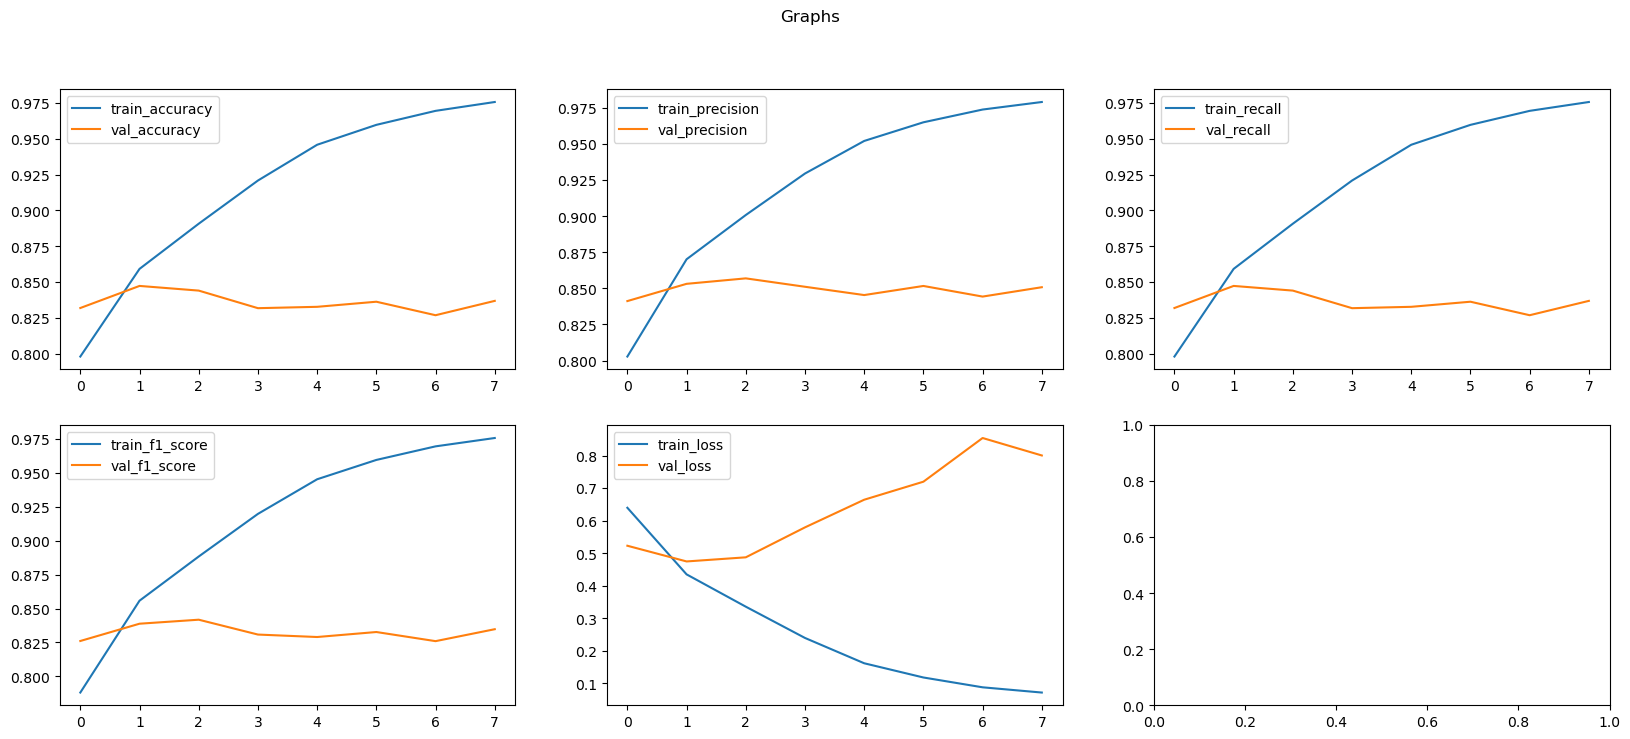

In [17]:
fig, ax = plt.subplots(2,3, figsize=(20, 8))
plt.suptitle("Graphs")
for i, name in enumerate(trainer.train_report.columns):
  plt.subplot(2,3,i+1)
  plt.plot(trainer.train_report[name], label=f"train_{name}")
  plt.plot(trainer.val_report[name], label=f"val_{name}")
  plt.legend()
plt.show()

In [18]:
trainer.train_report.to_csv("train_results.csv", index=False)
trainer.val_report.to_csv("val_results.csv", index=False)

In [19]:
last_checkpoint = {"epoch": "latest", "model": trainer.model.state_dict()}
torch.save(last_checkpoint, "latest_model_unfreezed.pt")